In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

import shutil
import gzip

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Forest covertype : loading data

In [7]:
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
dataset_name = "forest-cover-type"
out_zip = Path(os.getcwd() + "/data/forest-cover-type.zip")
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")

download(url, out_zip)
with gzip.open(out_zip, "rb") as f_in:
    with open(out, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

target = "Covertype"
bool_columns = [
    "Wilderness_Area1",
    "Wilderness_Area2",
    "Wilderness_Area3",
    "Wilderness_Area4",
    "Soil_Type1",
    "Soil_Type2",
    "Soil_Type3",
    "Soil_Type4",
    "Soil_Type5",
    "Soil_Type6",
    "Soil_Type7",
    "Soil_Type8",
    "Soil_Type9",
    "Soil_Type10",
    "Soil_Type11",
    "Soil_Type12",
    "Soil_Type13",
    "Soil_Type14",
    "Soil_Type15",
    "Soil_Type16",
    "Soil_Type17",
    "Soil_Type18",
    "Soil_Type19",
    "Soil_Type20",
    "Soil_Type21",
    "Soil_Type22",
    "Soil_Type23",
    "Soil_Type24",
    "Soil_Type25",
    "Soil_Type26",
    "Soil_Type27",
    "Soil_Type28",
    "Soil_Type29",
    "Soil_Type30",
    "Soil_Type31",
    "Soil_Type32",
    "Soil_Type33",
    "Soil_Type34",
    "Soil_Type35",
    "Soil_Type36",
    "Soil_Type37",
    "Soil_Type38",
    "Soil_Type39",
    "Soil_Type40",
]

int_columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

feature_columns = int_columns + bool_columns + [target]
to_remove = []
train = pd.read_csv(out, sep=",", low_memory=False, header=None, names=feature_columns)

File already exists.


<IPython.core.display.Javascript object>

In [8]:
train.shape

(581012, 55)

<IPython.core.display.Javascript object>

In [9]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

<IPython.core.display.Javascript object>

In [10]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>

In [11]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [12]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['Soil_Type1',
  'Soil_Type40',
  'Soil_Type12',
  'Soil_Type31',
  'Soil_Type20',
  'Soil_Type16',
  'Soil_Type13',
  'Soil_Type25',
  'Soil_Type15',
  'Wilderness_Area1',
  'Soil_Type22',
  'Soil_Type26',
  'Soil_Type10',
  'Soil_Type4',
  'Soil_Type36',
  'Soil_Type14',
  'Soil_Type2',
  'Soil_Type27',
  'Soil_Type33',
  'Soil_Type30',
  'Soil_Type35',
  'Soil_Type24',
  'Soil_Type11',
  'Soil_Type6',
  'Soil_Type18',
  'Soil_Type7',
  'Soil_Type17',
  'Soil_Type3',
  'Wilderness_Area4',
  'Wilderness_Area2',
  'Soil_Type8',
  'Soil_Type39',
  'Soil_Type37',
  'Soil_Type23',
  'Soil_Type38',
  'Soil_Type29',
  'Wilderness_Area3',
  'Soil_Type34',
  'Soil_Type28',
  'Soil_Type32',
  'Soil_Type19',
  'Soil_Type21',
  'Soil_Type5',
  'Soil_Type9'],
 'num_cols': [],
 'cat_cols': ['Hillshade_9am',
  'Horizontal_Distance_To_Roadways',
  'Aspect',
  'Horizontal_Distance_To_Fire_Points',
  'Slope',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Hydrology',


<IPython.core.display.Javascript object>

In [13]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [14]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [15]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [16]:
params

{'constant_cols': [],
 'bool_cols': ['Soil_Type1',
  'Soil_Type40',
  'Soil_Type12',
  'Soil_Type31',
  'Soil_Type20',
  'Soil_Type16',
  'Soil_Type13',
  'Soil_Type25',
  'Soil_Type15',
  'Wilderness_Area1',
  'Soil_Type22',
  'Soil_Type26',
  'Soil_Type10',
  'Soil_Type4',
  'Soil_Type36',
  'Soil_Type14',
  'Soil_Type2',
  'Soil_Type27',
  'Soil_Type33',
  'Soil_Type30',
  'Soil_Type35',
  'Soil_Type24',
  'Soil_Type11',
  'Soil_Type6',
  'Soil_Type18',
  'Soil_Type7',
  'Soil_Type17',
  'Soil_Type3',
  'Wilderness_Area4',
  'Wilderness_Area2',
  'Soil_Type8',
  'Soil_Type39',
  'Soil_Type37',
  'Soil_Type23',
  'Soil_Type38',
  'Soil_Type29',
  'Wilderness_Area3',
  'Soil_Type34',
  'Soil_Type28',
  'Soil_Type32',
  'Soil_Type19',
  'Soil_Type21',
  'Soil_Type5',
  'Soil_Type9'],
 'num_cols': [],
 'cat_cols': ['Hillshade_9am',
  'Horizontal_Distance_To_Roadways',
  'Aspect',
  'Horizontal_Distance_To_Fire_Points',
  'Slope',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Hydrology',


<IPython.core.display.Javascript object>

In [17]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    activation_num_first_layer=None,  # "tanh",
    output_activation="softmax",
    output_dim=np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/options.py:47: RuntimeWarning: Traceback (most recent call last):
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 44, in mish
    return _mish_custom_op(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 59, in _mish_custom_op
    return _activation_so.ops.addons_mish(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py", line 64, in ops
    self._ops = tf.load_op_library(get_path_to_datafile(self.relative_path))
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/load_library.py", line 58, in load_op_library
    lib_handle = py_tf.TF_LoadLibrary(library_filename)
tensorflow.python.framework.errors_impl.NotFoundError: /

<IPython.core.display.Javascript object>

In [18]:
model.get_layer("output")._build_input_shape

TensorShape([None, 84])

<IPython.core.display.Javascript object>

In [19]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 10, 16)       92704       input_cat[0][0]                  
__________________________________________________________________________________________________
block_cat_0_conv (LocallyConnec (None, 10, 4)        640         large_emb[0][0]                  
__________________________________________________________________________________________________
block_cat_0_activation (Activat (None, 10, 4)        0           block_cat_0_conv[0][0]           
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [20]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

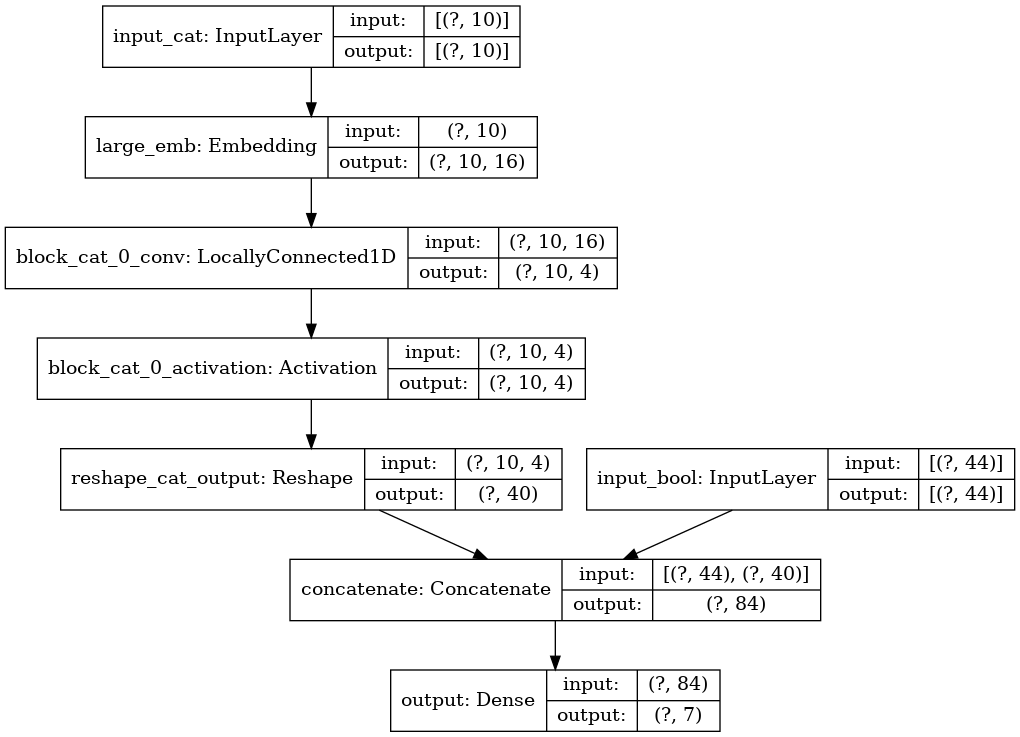

<IPython.core.display.Javascript object>

In [21]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [22]:
y_train.shape

(475918,)

<IPython.core.display.Javascript object>

In [23]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [24]:
class_weight = {}
for i, count in enumerate(counts):
    class_weight[i] = count
class_weight

{0: 2.741573680966398,
 1: 2.0547184637037934,
 2: 16.045785569790965,
 3: 213.41614349775784,
 4: 62.07356201904265,
 5: 33.20667038794306,
 6: 28.304864993457834}

<IPython.core.display.Javascript object>

class_weight = {}
for i, count in enumerate(counts):
    class_weight[i] = 1
class_weight

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
    class_weight=class_weight
)

Epoch 1/2000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


465/465 - 2s - loss: 13.3051 - val_loss: 1.8080
Epoch 2/2000
465/465 - 2s - loss: 11.3008 - val_loss: 1.3217
Epoch 3/2000
465/465 - 2s - loss: 8.4089 - val_loss: 1.1830
Epoch 4/2000
465/465 - 2s - loss: 7.1590 - val_loss: 1.1203
Epoch 5/2000
465/465 - 2s - loss: 6.5057 - val_loss: 1.0665
Epoch 6/2000
465/465 - 2s - loss: 6.0290 - val_loss: 1.0261
Epoch 7/2000
465/465 - 2s - loss: 5.6266 - val_loss: 0.9850
Epoch 8/2000
465/465 - 2s - loss: 5.2952 - val_loss: 0.9501
Epoch 9/2000
465/465 - 2s - loss: 5.0494 - val_loss: 0.9268
Epoch 10/2000
465/465 - 2s - loss: 4.8690 - val_loss: 0.9139
Epoch 11/2000
465/465 - 2s - loss: 4.7298 - val_loss: 0.8973
Epoch 12/2000
465/465 - 2s - loss: 4.6176 - val_loss: 0.8877
Epoch 13/2000
465/465 - 2s - loss: 4.5234 - val_loss: 0.8833
Epoch 14/2000
465/465 - 2s - loss: 4.4425 - val_loss: 0.8769
Epoch 15/2000
465/465 - 2s - loss: 4.3736 - val_loss: 0.8712
Epoch 16/2000
465/465 - 2s - loss: 4.3145 - val_loss: 0.8645
Epoch 17/2000
465/465 - 2s - loss: 4.2633 - 

<IPython.core.display.Javascript object>

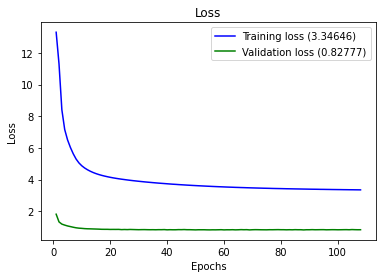

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = accuracy_score(
    y_true=y_valid, y_pred=np.argmax(model.predict(input_valid), axis=1),
)
model_auc

0.6461525366019748

<IPython.core.display.Javascript object>

In [28]:
model_auc = balanced_accuracy_score(
    y_true=y_test, y_pred=np.argmax(model.predict(input_test), axis=1),
)
model_auc

0.6885810266195612

<IPython.core.display.Javascript object>

In [29]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [30]:
# This needs to be fixed to work for multiclass

<IPython.core.display.Javascript object>

In [31]:
probs, explanations = predict(model, input_test)

ValueError: cannot reshape array of size 308 into shape (44,1)

<IPython.core.display.Javascript object>

In [ ]:
probs, encoded_output = encode(model, input_test)

In [ ]:
y_test.shape

In [ ]:
encoded_output.shape

In [ ]:
explanations.shape

In [ ]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

In [ ]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

## Explain global

In [ ]:
probs_train, explanations_train = predict(model, input_train)

In [ ]:
global_explain = np.sum(explanations_train, axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

In [ ]:
global_explain

In [ ]:
explain_plot(global_explain, all_cols)

## Explain local

In [ ]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
np.unique(y_test, return_counts=True)

In [ ]:
y_test

In [ ]:
target_encoder.classes_

In [ ]:
confusion_matrix(
    y_true=y_test,
    y_pred=model.predict(input_test).reshape(-1) >= 0.5,
    # labels=target_encoder.classes_,
)